In [1]:
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pathlib import Path
from pvlib.irradiance import get_extra_radiation
from pvlib.solarposition import get_solarposition
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer,
)
from timezonefinder import TimezoneFinder
from tqdm import tqdm
from lightgbm import LGBMRegressor

from models_utils.preprocessing import add_night_mark


import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

# Constants

In [2]:
PROJECT_PATH = Path.cwd() / "solar_irradiance_forecasting"
DATA_PATH = PROJECT_PATH / "data"
RAW_PATH = DATA_PATH / "raw"
WEATHER_PATH = RAW_PATH / "weather/open-meteo_sa_tower_4f_2022_01_01_2023_01_18.csv"
IRRAD_PARH = RAW_PATH / "irradiance/south_africa/cams_johannesburg_2022_01_01_2023_01_17.csv"

LATITUDE = -26.05098
LONGITUDE = 28.10077
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

COS_EPS = 10 ** (-3)

FEATURES_COLUMNES = [
    "temperature_2m (°C)",
    "relativehumidity_2m (%)",
    # "precipitation (mm)",
    # "cloudcover (%)",
    # "windspeed_10m (km/h)",
    "windspeed_100m (km/h)",
]

TARGET_COLUMNES = [
    "direct_noise",
    "DHI",
]

TIME_COLUMN = "time"
TEMPERATURE_COL = "temperature_2m (°C)"

# Data read

In [3]:
weather_data = pd.read_csv(WEATHER_PATH, parse_dates=["time"], skiprows=3)
irrad_data = pd.read_csv(
    IRRAD_PARH,
    usecols=["# Observation period", "GHI", "BHI", "DHI"],
    skiprows=67,
    sep=";",
)

# Preprocessing

## Weather

In [4]:
dropping_columns = list(filter(lambda col: "radia" in col or "snowfall" in col, weather_data.columns))
weather_data.drop(columns=dropping_columns, inplace=True)
weather_data = weather_data.assign(time=weather_data.time.dt.tz_localize(TIMEZONE))

## Irrad

In [5]:
irrad_data = irrad_data.assign(
    time=pd.to_datetime(
        irrad_data["# Observation period"]
        .str
        .split("/")
        .apply(lambda l: l[0])
    )
    .dt.tz_localize(TIMEZONE)
)
irrad_data.drop(columns=["# Observation period",], inplace=True)
irrad_data = irrad_data.resample('1H', on="time").mean().reset_index()

## Merge

In [6]:
merged_data = irrad_data.merge(weather_data, on=TIME_COLUMN)
prepared_data = merged_data.copy()
prepared_data = add_night_mark(
    merged_data,
    lat=LATITUDE,
    lon=LONGITUDE,
    timezone=TIMEZONE,
    date_column=TIME_COLUMN,
    mark_column="night_mark",
    night_indent=timedelta(),
)
mask = ~prepared_data["night_mark"]
prepared_data = prepared_data[mask].reset_index(drop=True)
prepared_data.drop(columns=["night_mark"], inplace=True)
prepared_data = (
    prepared_data
    .assign(
        year=prepared_data.time.dt.year,
        day_of_year=prepared_data.time.dt.day_of_year,
        extrater_irrad=0,
        zenith_coef=0,
    )
)
for year in prepared_data.year.unique():
    year_mask = prepared_data.year == year
    doys = prepared_data.loc[year_mask, "day_of_year"]
    prepared_data.loc[year_mask, "extrater_irrad"] = get_extra_radiation(doys, year=year)
for temperature in tqdm(prepared_data[TEMPERATURE_COL].unique()):
    temp_mask = prepared_data[TEMPERATURE_COL] == temperature
    prepared_data.loc[temp_mask, "zenith_coef"] = np.cos(get_solarposition(
        prepared_data.loc[temp_mask, TIME_COLUMN],
        latitude=LATITUDE,
        longitude=LONGITUDE,
        temperature=temperature)["zenith"].values)
zenith_coef = prepared_data["zenith_coef"].values
prepared_data["zenith_coef"] = prepared_data["zenith_coef"].where(
    np.abs(zenith_coef) > COS_EPS,
    zenith_coef + np.sign(zenith_coef) * COS_EPS,
)
prepared_data["direct_noise"] = prepared_data["extrater_irrad"] - prepared_data["BHI"] / prepared_data["zenith_coef"]
prepared_data.drop(columns=["year", "day_of_year", "extrater_irrad", "zenith_coef",], inplace=True)

100%|██████████| 251/251 [00:01<00:00, 167.08it/s]


In [7]:
targets = prepared_data[TARGET_COLUMNES]
features = prepared_data[FEATURES_COLUMNES]

# Data separation

In [8]:
noise_x_train, noise_x_test, noise_y_train, noise_y_test = train_test_split(features, targets[["direct_noise"]], test_size=0.33, random_state=42)
dhi_x_train, dhi_x_test, dhi_y_train, dhi_y_test = train_test_split(features, targets[["DHI"]], test_size=0.33, random_state=42)

### Features

#### Source

array([[<AxesSubplot: title={'center': 'temperature_2m (°C)'}>,
        <AxesSubplot: title={'center': 'relativehumidity_2m (%)'}>],
       [<AxesSubplot: title={'center': 'windspeed_100m (km/h)'}>,
        <AxesSubplot: >]], dtype=object)

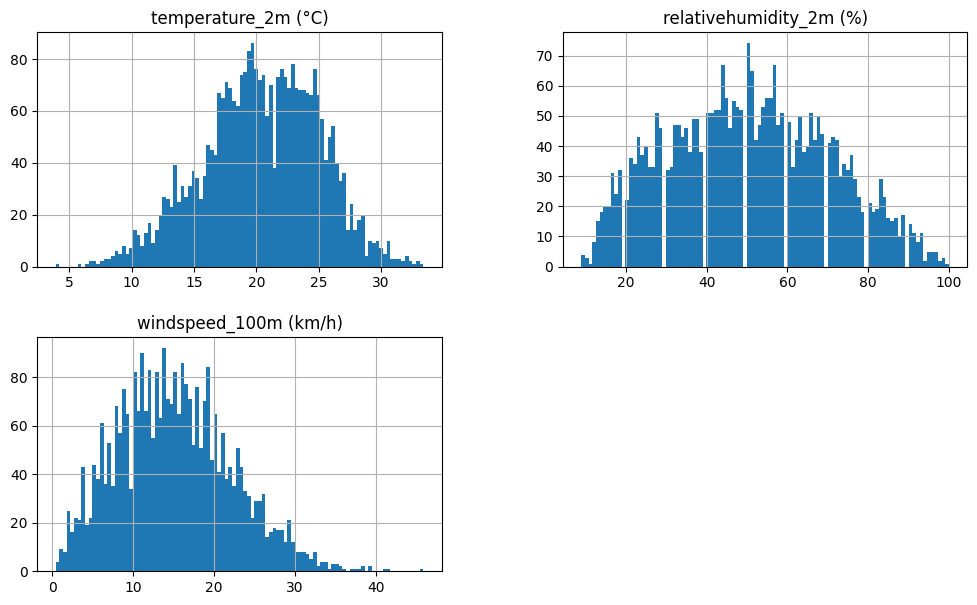

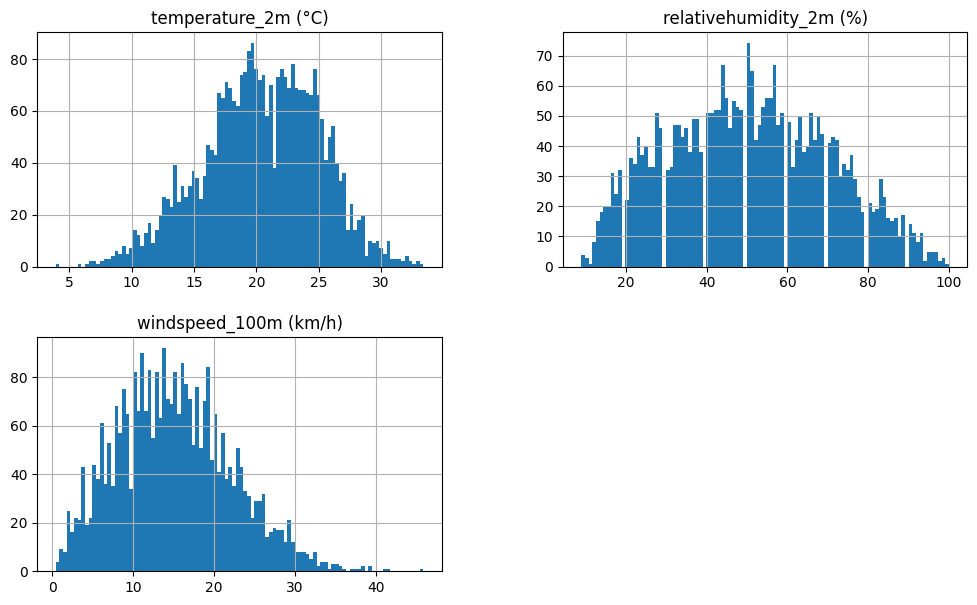

In [9]:
display(noise_x_train.hist(figsize=(12,7), bins=100))
dhi_x_train.hist(figsize=(12,7), bins=100);

#### Power transofrmation

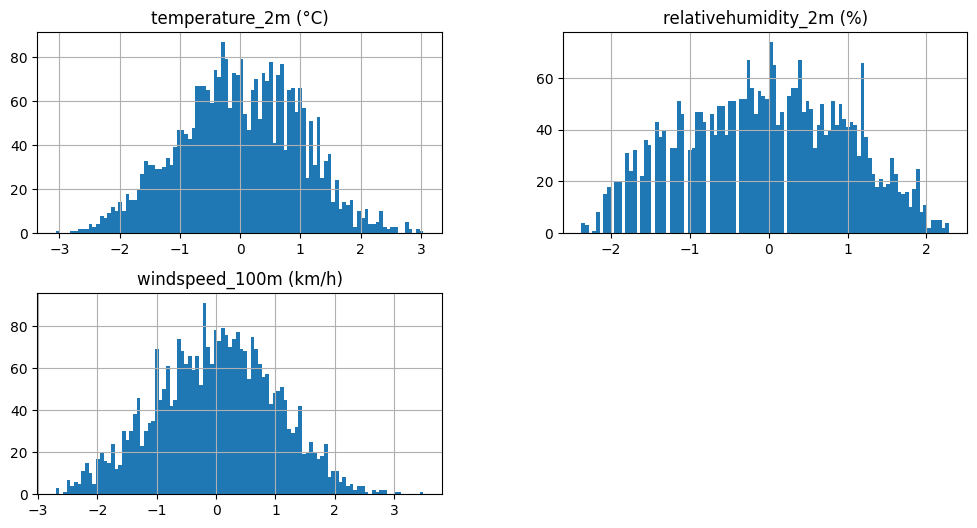

In [10]:
p_noise_x_trfmr = PowerTransformer().fit(noise_x_train)
noise_x_train_p_trfrmd = pd.DataFrame(
    data=p_noise_x_trfmr.transform(noise_x_train),
    columns= noise_x_train.columns,
)
noise_x_test_p_trfrmd = pd.DataFrame(
    data=p_noise_x_trfmr.transform(noise_x_test),
    columns= noise_x_test.columns,
)
noise_x_train_p_trfrmd.hist(figsize=(12,6), bins=100);

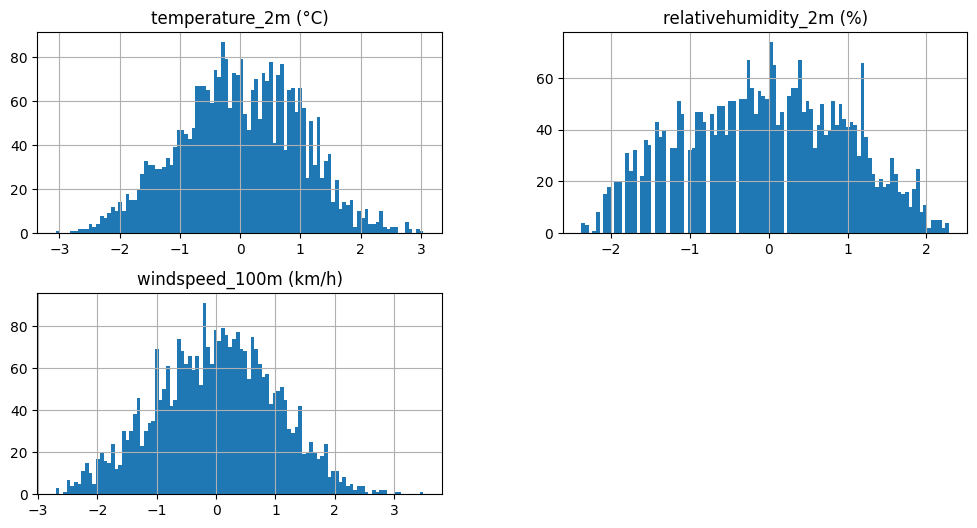

In [11]:
p_dhi_x_trfmr = PowerTransformer().fit(dhi_x_train)
dhi_x_train_p_trfrmd = pd.DataFrame(
    data=p_dhi_x_trfmr.transform(dhi_x_train),
    columns=dhi_x_train.columns,
)
dhi_x_test_p_trfrmd = pd.DataFrame(
    data=p_dhi_x_trfmr.transform(dhi_x_test),
    columns=dhi_x_test.columns,
)
dhi_x_train_p_trfrmd.hist(figsize=(12,6), bins=100);

#### Quantile transformation

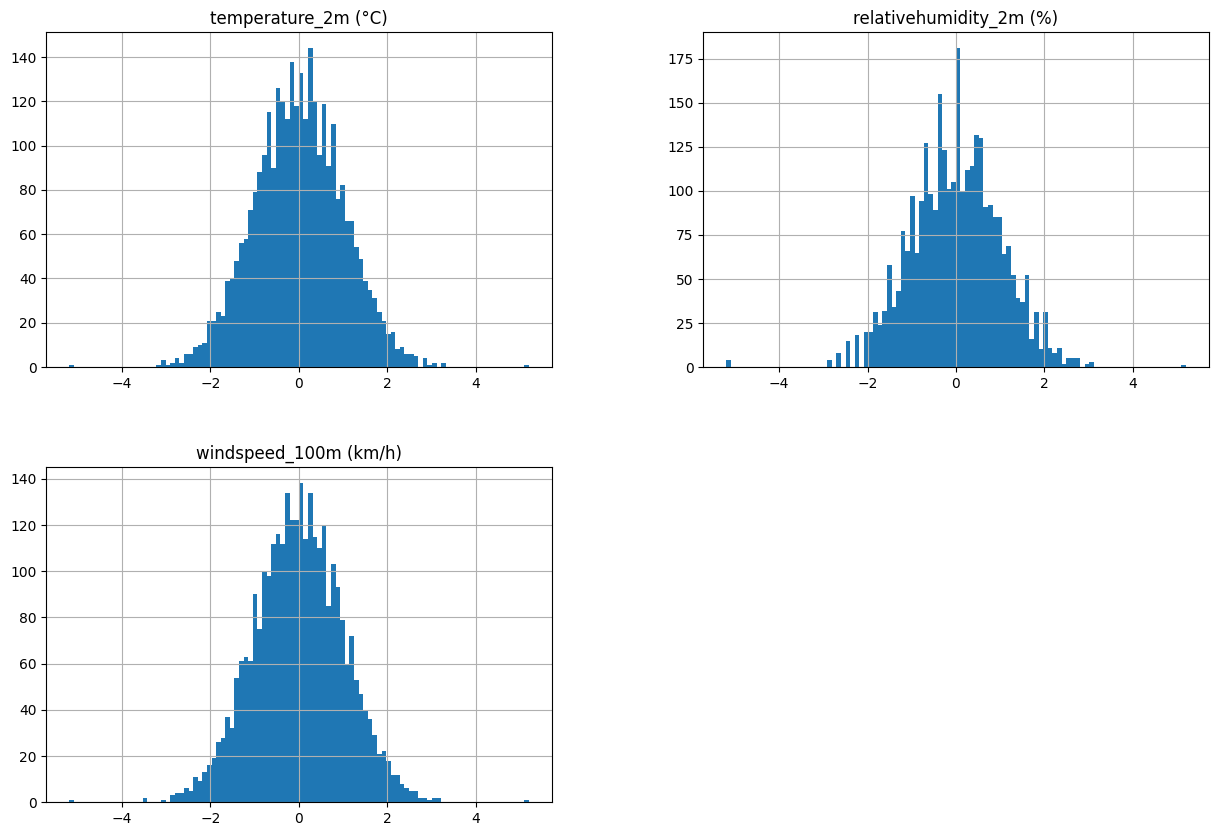

In [12]:
q_noise_x_trfmr = QuantileTransformer(output_distribution="normal").fit(noise_x_train)
noise_x_train_q_trfrmd = pd.DataFrame(
    data=q_noise_x_trfmr.transform(noise_x_train),
    columns= noise_x_train.columns,
)
noise_x_test_q_trfrmd = pd.DataFrame(
    data=q_noise_x_trfmr.transform(noise_x_test),
    columns= noise_x_test.columns,
)
noise_x_train_q_trfrmd.hist(figsize=(15,10), bins=100);

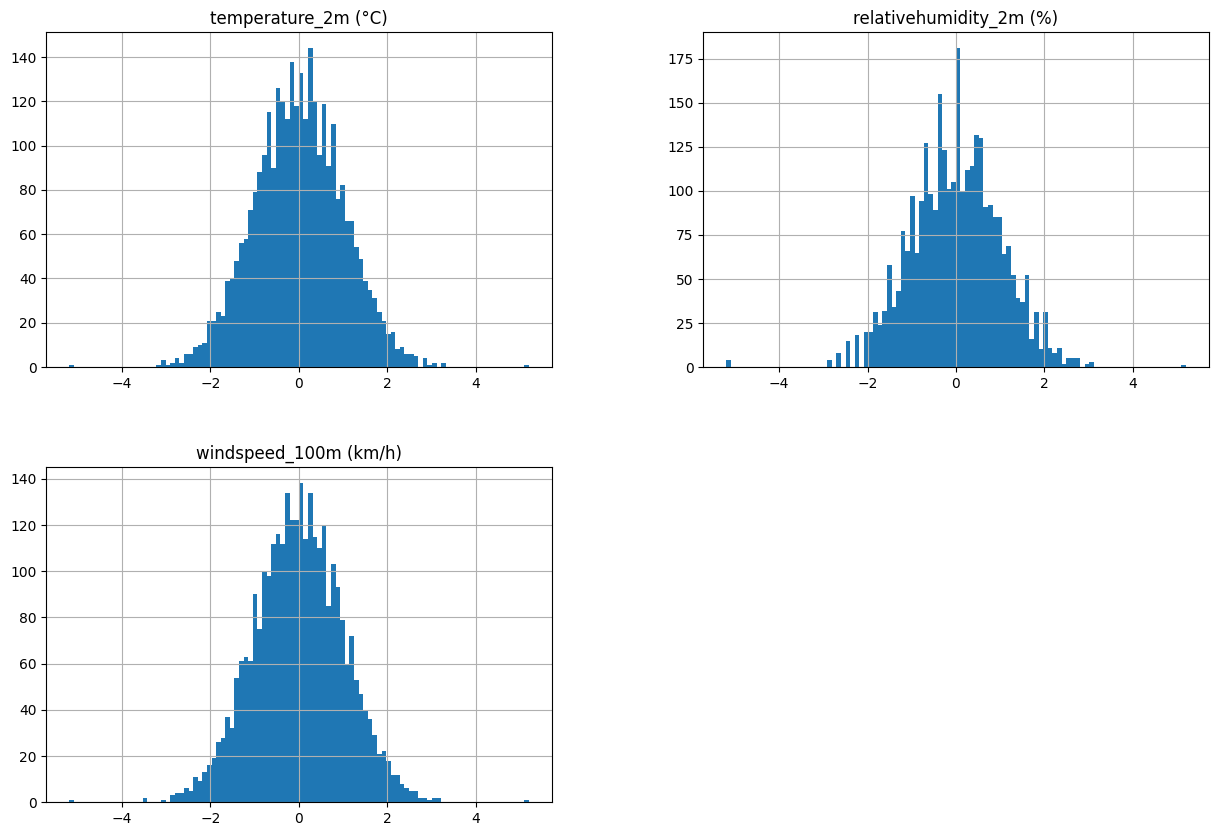

In [13]:
q_dhi_x_trfmr = QuantileTransformer(output_distribution="normal").fit(dhi_x_train)
dhi_x_train_q_trfrmd = pd.DataFrame(
    data=q_dhi_x_trfmr.transform(dhi_x_train),
    columns=dhi_x_train.columns,
)
dhi_x_test_q_trfrmd = pd.DataFrame(
    data=q_dhi_x_trfmr.transform(dhi_x_test),
    columns=dhi_x_test.columns,
)
dhi_x_train_q_trfrmd.hist(figsize=(15,10), bins=100);

### Targets

#### Source

In [14]:
display(noise_y_train.describe())
dhi_y_train.describe()

,direct_noise
count,3084.000000
mean,1368.291164
std,152.386181
min,-2486.584925
25%,1337.685533
50%,1375.003686
75%,1403.947184
max,4552.417055


,DHI
count,3084.000000
mean,2.471348
std,2.238870
min,0.000000
25%,0.567395
50%,1.976862
75%,3.734413
max,9.556660


array([[<AxesSubplot: title={'center': 'direct_noise'}>]], dtype=object)

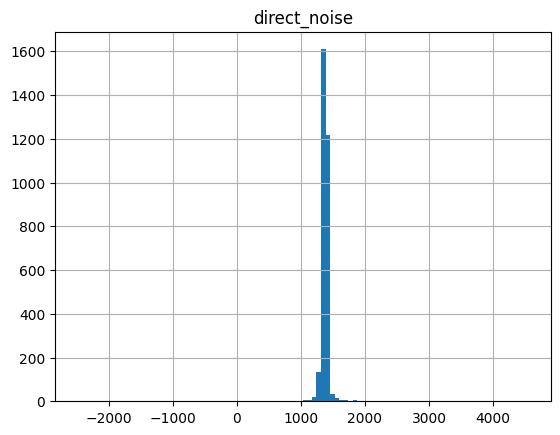

In [15]:
noise_y_train.hist(bins=100)

array([[<AxesSubplot: title={'center': 'DHI'}>]], dtype=object)

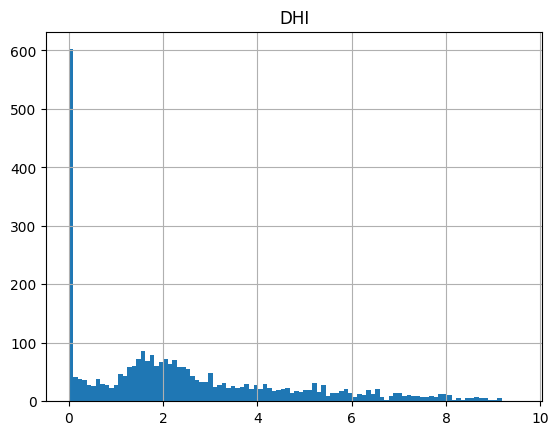

In [16]:
dhi_y_train.hist(bins=100)

#### Power transformation

array([[<AxesSubplot: title={'center': 'direct_noise'}>]], dtype=object)

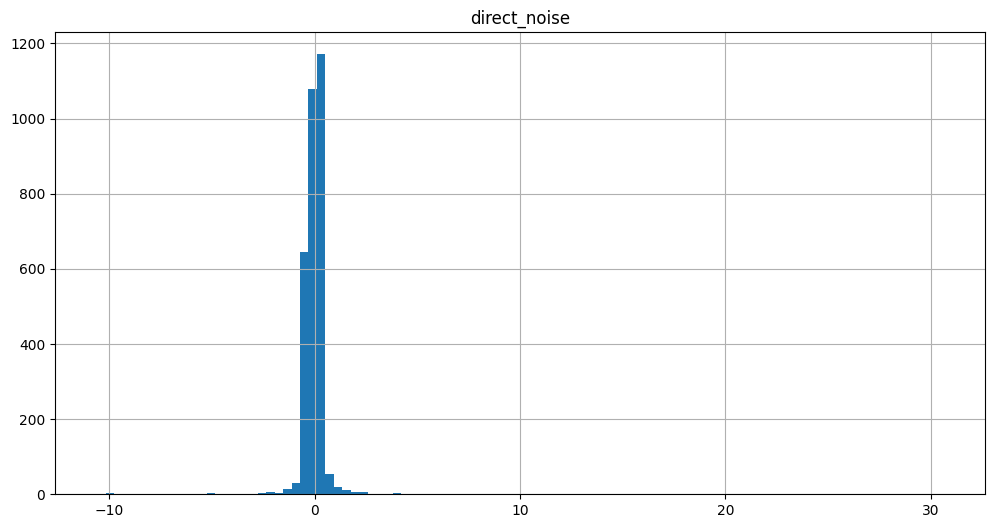

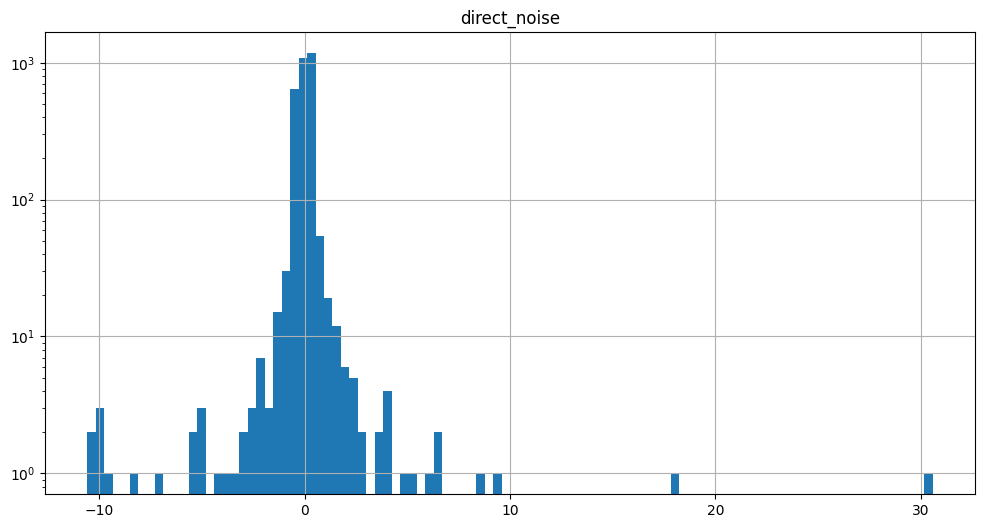

In [17]:
p_noise_y_trfmr = PowerTransformer().fit(noise_y_train)
noise_y_train_p_trfrmd = pd.DataFrame(
    data=p_noise_y_trfmr.transform(noise_y_train),
    columns= noise_y_train.columns,
)
display(noise_y_train_p_trfrmd.hist(figsize=(12,6), bins=100))
noise_y_train_p_trfrmd.hist(figsize=(12,6), bins=100, log=True);

array([[<AxesSubplot: title={'center': 'DHI'}>]], dtype=object)

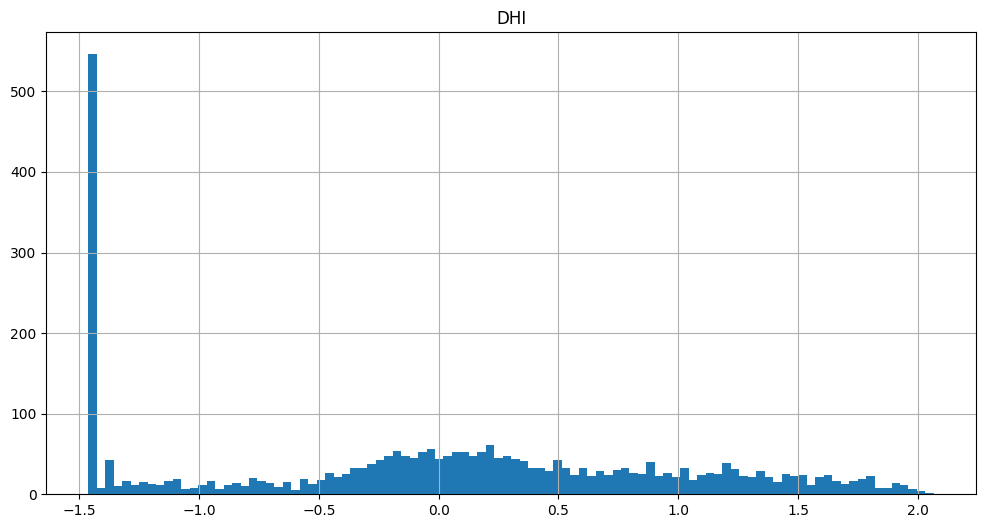

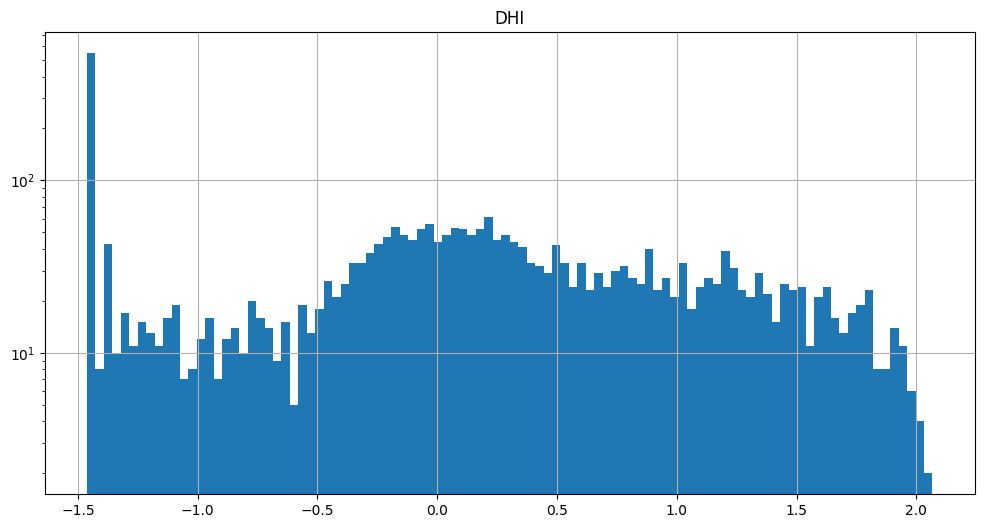

In [18]:
p_dhi_y_trfmr = PowerTransformer().fit(dhi_y_train)
dhi_y_train_p_trfrmd = pd.DataFrame(
    data=p_dhi_y_trfmr.transform(dhi_y_train),
    columns= dhi_y_train.columns,
)
display(dhi_y_train_p_trfrmd.hist(figsize=(12,6), bins=100))
dhi_y_train_p_trfrmd.hist(figsize=(12,6), bins=100, log=True);

# Fit

## Without preprocessing

In [19]:
noise_model = LGBMRegressor()
noise_model.fit(noise_x_train, noise_y_train);

In [20]:
dhi_model = LGBMRegressor()
dhi_model.fit(dhi_x_train, dhi_y_train);

## Features prepared only

In [21]:
noise_feat_model = LGBMRegressor()
noise_feat_model.fit(noise_x_train_p_trfrmd, noise_y_train);

In [22]:
dhi_feat_model = LGBMRegressor()
dhi_feat_model.fit(dhi_x_train_p_trfrmd, dhi_y_train);

## Features and targets prepared

In [23]:
noise_prep_model = LGBMRegressor()
noise_prep_model.fit(noise_x_train_p_trfrmd, noise_y_train_p_trfrmd);

In [24]:
dhi_prep_model = LGBMRegressor()
dhi_prep_model.fit(dhi_x_train_p_trfrmd, dhi_y_train_p_trfrmd);

# Score

## Without preprocessing

In [25]:
noise_prediction = noise_model.predict(noise_x_test)
dhi_prediction = dhi_model.predict(dhi_x_test)

noise_mse = mean_squared_error(noise_y_test, noise_prediction)
noise_r2 = r2_score(noise_y_test, noise_prediction)
dhi_mse = mean_squared_error(dhi_y_test, dhi_prediction)
dhi_r2 = r2_score(dhi_y_test, dhi_prediction)

print(f"{noise_mse=} | {noise_r2=} | {dhi_mse=} | {dhi_r2=}")

noise_mse=50302.418337221214 | noise_r2=-0.03449966094333501 | dhi_mse=4.1564069273420605 | dhi_r2=0.13242216682497399


## Features prepared only

In [26]:
noise_feat_prediction = noise_model.predict(noise_x_test_p_trfrmd)
dhi_feat_prediction = dhi_model.predict(dhi_x_test_p_trfrmd)

noise_feat_mse = mean_squared_error(noise_y_test, noise_feat_prediction)
noise_feat_r2 = r2_score(noise_y_test, noise_feat_prediction)
dhi_feat_mse = mean_squared_error(dhi_y_test, dhi_feat_prediction)
dhi_feat_r2 = r2_score(dhi_y_test, dhi_feat_prediction)

print(f"{noise_feat_mse=} | {noise_feat_r2=} | {dhi_feat_mse=} | {dhi_feat_r2=}")

noise_feat_mse=52709.60147625072 | noise_feat_r2=-0.08400483829803673 | dhi_feat_mse=7.273125637925091 | dhi_feat_r2=-0.5181387895039189


## Features and targets prepared

In [34]:
noise_prep_prediction = noise_model.predict(noise_x_test_p_trfrmd)
noise_prep_prediction = p_noise_y_trfmr.inverse_transform(
    pd.DataFrame(
        data=noise_prep_prediction,
        columns=noise_y_test.columns
    )
)
dhi_prep_prediction = dhi_model.predict(dhi_x_test_p_trfrmd)
dhi_prep_prediction = p_dhi_y_trfmr.inverse_transform(
    pd.DataFrame(
        data=dhi_prep_prediction,
        columns=dhi_y_test.columns
    )
)

noise_prep_mse = mean_squared_error(noise_y_test, noise_prep_prediction)
noise_prep_r2 = r2_score(noise_y_test, noise_prep_prediction)
dhi_prep_mse = mean_squared_error(dhi_y_test, dhi_prep_prediction)
dhi_prep_r2 = r2_score(dhi_y_test, dhi_prep_prediction)

print(f"{noise_prep_mse=} | {noise_prep_r2=} | {dhi_prep_mse=} | {dhi_prep_r2=}")

noise_prep_mse=7689045428.4869375 | noise_prep_r2=-158128.87032597302 | dhi_prep_mse=7.3512969000520405 | dhi_prep_r2=-0.5344556842156756
